In [69]:
# Set path for module imports
import sys
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

%load_ext autoreload
%autoreload 2

# Run this cell to import necessary libraries
import json
import yaml
import pickle
import logging
import numpy as np
import matplotlib.pyplot as plt

# --- Bokeh Imports for Jupyter (Corrected) ---
from bokeh.io import output_notebook, show
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, Slider, Div
from bokeh.plotting import figure
from bokeh.application import Application
from bokeh.application.handlers.function import FunctionHandler
# --- Imports for the new interactive framework ---
import plotly.graph_objects as go
from ipywidgets import Dropdown, FloatSlider, Label, VBox, HBox, Output, Button, Textarea
from IPython.display import display

# --- Your Pipeline's Imports ---
# Make sure your scint_analysis package is importable
# (You may need to add its path using sys.path.insert)
try:
    from scint_analysis import config, pipeline, plotting
    from scint_analysis.analysis import lorentzian_model_3_comp, lorentzian_model_2_comp, lorentzian_model_1_comp
    from scint_analysis.core import ACF
    from scint_analysis.config import update_fitting_parameter, update_pipeline_parameter, update_yaml_guesses
except ImportError as e:
    logging.error(f"Could not import scint_analysis. Make sure it's in your Python path. {e}")

# --- 1. Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey_dsa.yaml'

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")
    # Stop execution if config fails
    raise

# --- 2. Initialize and Run the Pipeline ---
print("\n--- Initializing and Running Scintillation Pipeline ---")
# Create an instance of the main pipeline controller
#scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

# This single .run() call executes all the steps in the correct order:
# - Loads and masks data
# - Characterizes off-pulse noise (NEW)
# - Calculates ACFs using the noise model for normalization
#scint_pipeline.run()
print("--- Pipeline Execution Finished ---")

INFO: Loading burst configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey_dsa.yaml
INFO: Loading telescope configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/../telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "casey",
  "input_data_path": "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/casey.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 5.0,
      "padding_factor": 0.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0
    },
    "acf": {
      "num_subbands": 2,
      "max_lag_mhz": 200.0,
      "use_snr_subbanding": false,
      "enable_intra_pulse_analysis": true,
      "intra_pulse_time_bins": 5
    },
 

In [67]:
# --- 2. Load Analysis Configuration ---
# Load the main config file to get pipeline parameters
try:
    with open(BURST_CONFIG_PATH, 'r') as f:
        analysis_config = yaml.safe_load(f)
    # Get the lag range used for fitting from the config
    fit_lag_mhz = analysis_config.get('analysis', {}).get('fitting', {}).get('fit_lagrange_mhz', 30.0)
    logging.info(f"Loaded fit_lagrange_mhz: {fit_lag_mhz} MHz")
except FileNotFoundError:
    logging.warning(f"Config file not found at {BURST_CONFIG_PATH}. Using default fit range of 30.0 MHz.")
    fit_lag_mhz = 30.0
    
new_fit_lag = None

if new_fit_lag:
    # 2. Define the parameter you want to change and its new value
    parameter_to_change = 'fit_lagrange_mhz'
    new_fit_range = new_fit_lag # Let's change it from 45.0 to 30.0

    # 3. Call the function to update the YAML file
    update_fitting_parameter(
        config_path=BURST_CONFIG_PATH,
        param_name=parameter_to_change,
        new_value=new_fit_range
    )

# --- Load Pre-calculated ACF Data ---
SUBBAND_INDEX = 0 # Choose which sub-band to analyze (0, 1, 2...)
ACF_RESULTS_PATH = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/cache/casey/casey_acf_results.pkl' # Adjust path if needed

try:
    with open(ACF_RESULTS_PATH, 'rb') as f:
        acf_results = pickle.load(f)
    logging.info(f"Successfully loaded ACF results from {ACF_RESULTS_PATH}")

    # Create a clean ACF object for the selected sub-band
    lags = acf_results['subband_lags_mhz'][SUBBAND_INDEX]
    data = acf_results['subband_acfs'][SUBBAND_INDEX]
    errors = None #acf_results.get('subband_acfs_err', [np.ones_like(data)])[SUBBAND_INDEX]

    if errors is None:
        errors = np.ones_like(data)
        
    acf_obj = ACF(acf_data=data, lags_mhz=lags, acf_err=errors) #

except FileNotFoundError:
    logging.error(f"ERROR: ACF results file not found at {ACF_RESULTS_PATH}.")
except Exception as e:
    logging.error(f"An error occurred loading or processing the ACF data: {e}")

# --- 1. Model Configuration Hub ---
# This dictionary stores all the information needed for each model
MODEL_CONFIG = {
    '1-Component Lorentzian': {
        'func': lorentzian_model_1_comp, #
        'param_names': ['gamma1', 'm1', 'c1'],
        'p0':          [0.1,      1.0,  0.0],
        'bounds':      [(1e-4, 4), (0, 2), (-0.2, 0.2)]
    },
    '2-Component Lorentzian': {
        'func': lorentzian_model_2_comp, #
        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'c2'],
        'p0':          [0.05,     0.5,  0.5,      0.5,  0.0],
        'bounds':      [(1e-4, 4), (0, 2), (1e-4, 8), (0, 2), (-0.2, 0.2)]
    },
    '3-Component Lorentzian': {
        'func': lorentzian_model_3_comp, #
        'param_names': ['gamma1', 'm1', 'gamma2', 'm2', 'gamma3', 'm3', 'c3'],
        'p0':          [0.05,     0.5,  0.2,      0.4,  0.8,      0.3,  0.0],
        'bounds':      [(1e-4, 2), (0, 2), (1e-4, 4), (0, 2), (1e-4, 8), (0, 2), (-0.2, 0.2)]
    }
}

# --- 2. Create Top-Level Widgets ---
# Dropdown for model selection
model_selector = Dropdown(
    options=list(MODEL_CONFIG.keys()),
    value='2-Component Lorentzian',
    description='Select Model:',
    style={'description_width': 'initial'}
)
# An output widget to act as a container for the dynamic UI
app_container = Output()


# --- 3. Dynamic Application Builder Function ---
def create_interactive_fitter(model_name):
    """Builds and displays the interactive fitter for a given model name."""
    config = MODEL_CONFIG[model_name]
    model_func = config['func']
    param_names = config['param_names']
    p0 = config['p0']
    bounds = config['bounds']

    # --- NEW: Create a mask to exclude the zero-lag point from fitting ---
    fit_mask = (acf_obj.lags != 0)

    # Create Plotly FigureWidgets
    fig = go.FigureWidget(layout=go.Layout(title=f"Interactive Fit: {model_name}", xaxis_title="Lag (MHz)"))
    
    fig.add_vrect(
        x0=-fit_lag_mhz, x1=fit_lag_mhz,
        fillcolor="lightgrey", opacity=0.3,
        layer="below", line_width=0,
        annotation_text="Fit Region", annotation_position="top left"
    )
    
    colors = np.array(['navy'] * len(acf_obj.lags), dtype=object)
    colors[~fit_mask] = 'lightgrey' # Make the zero-lag point grey
    fig.add_trace(go.Scatter(x=acf_obj.lags, y=acf_obj.acf, mode='markers', name='ACF Data',
                             marker=dict(color=colors, size=6)))
    fig.add_trace(go.Scatter(x=acf_obj.lags, y=model_func(acf_obj.lags, *p0), mode='lines', name='Model', line_color='crimson'))

    fig_res = go.FigureWidget(layout=go.Layout(title="Residuals", xaxis_title="Lag (MHz)"))
    fig_res.add_trace(go.Scatter(x=acf_obj.lags[fit_mask], y=(acf_obj.acf - model_func(acf_obj.lags, *p0))[fit_mask], mode='lines', line_color='black'))

    # Create ipywidgets dynamically based on the selected model
    sliders = {
        name: FloatSlider(value=val, min=low, max=high, step=(high-low)/500, description=name, continuous_update=True)
        for name, val, (low, high) in zip(param_names, p0, bounds)
    }
    gof_label = Label(value="Reduced Chi-Squared: N/A")

    # Define the update function inside this scope
    def update_fit(change):
        params = [s.value for s in sliders.values()]
        new_model_y = model_func(acf_obj.lags, *params)
        
        # Update the full model line on the plot
        with fig.batch_update():
            fig.data[1].y = new_model_y
        
        # --- MODIFIED: Use the mask for residuals and GoF calculation ---
        new_resid = acf_obj.acf - new_model_y
        with fig_res.batch_update():
            fig_res.data[0].x = acf_obj.lags[fit_mask]
            fig_res.data[0].y = new_resid[fit_mask]
            
        err = acf_obj.err
        if err is not None:
            # Calculate GoF only on the points included in the fit
            dof = len(acf_obj.acf[fit_mask]) - len(params)
            if dof > 0:
                chisqr = np.sum((new_resid[fit_mask] / err[fit_mask])**2)
                redchi = chisqr / dof
                gof_label.value = f"Reduced Chi-Squared (fit): {redchi:.3f}"

    for slider in sliders.values():
        slider.observe(update_fit, names='value')
        
    # --- NEW: Create a callback for the button click ---
    def on_print_button_clicked(b):
        # Get the key for the YAML file (e.g., '2c_lor')
        model_key = model_name.split('-')[0].lower().replace('component', 'c') + '_lor'

        # Start building the string
        output_str = f"'{model_key}': {{\n"
        
        # Add each parameter from the sliders
        for name, slider in sliders.items():
            output_str += f"    '{name}': {slider.value:.3f},\n"
        
        output_str += "}"
        
        # Set the textarea value to the formatted string
        output_textarea.value = output_str

    print_button.on_click(on_print_button_clicked)

    # --- MODIFIED: Add the new button and textarea to the layout ---
    controls = VBox(list(sliders.values()) + [gof_label, print_button, output_textarea])
    plots = VBox([fig, fig_res])
    app_layout = HBox([controls, plots])
    
    display(app_layout)
    update_fit(None)


# --- 4. Main Callback to Re-build the UI on Dropdown Change ---
@app_container.capture(clear_output=True)
def on_model_change(change):
    model_name = change['new']
    create_interactive_fitter(model_name)

model_selector.observe(on_model_change, names='value')

# --- 5. Display the Top-Level UI and Trigger Initial Build ---
display(VBox([model_selector, app_container]))
# Manually trigger the first build when the cell is run
create_interactive_fitter(model_selector.value)

INFO: Loaded fit_lagrange_mhz: 30.0 MHz
INFO: Successfully loaded ACF results from /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/cache/casey/casey_acf_results.pkl


NameError: name 'print_button' is not defined

In [59]:
# 1. Define the model key. This MUST match the key in MODEL_CONFIG and analysis.py
#    (e.g., '1c_lor', '2c_lor', '3c_lor')
model_to_update = '2c_lor'

# 2. Create a dictionary with the good parameter values you found from the sliders
good_guesses_from_slider = {
    'l2_gamma1': 1.55,
    'l2_m1': 0.29,
    'l2_gamma2':5.33,
    'l2_m2':0.58,
    'l2_c2': 0.01
}

# 3. Call the function to update the YAML file
update_yaml_guesses(
    config_path=CONFIG_PATH,
    model_name=model_to_update,
    new_params_dict=good_guesses_from_slider
)

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")
    # Stop execution if config fails
    raise

INFO: Loading burst configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey_dsa.yaml
INFO: Loading telescope configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/../telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.


Successfully updated initial guesses for '2c_lor' in ../configs/bursts/casey_dsa.yaml
--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "casey",
  "input_data_path": "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/casey.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 5.0,
      "padding_factor": 0.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0
    },
    "acf": {
      "num_subbands": 2,
      "max_lag_mhz": 200.0,
      "use_snr_subbanding": false,
      "enable_intra_pulse_analysis": true,
      "intra_pulse_time_bins": 5
    },
   

In [64]:
# 2. Define the parameter you want to change and its new value
parameter_to_change = 'halt_after_acf'
new_fit_range = False # Let's change it from 45.0 to 30.0

# 3. Call the function to update the YAML file
update_pipeline_parameter(
    config_path=BURST_CONFIG_PATH,
    param_name=parameter_to_change,
    new_value=False,
)


Successfully updated 'halt_after_acf' to 'False' in /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey_dsa.yaml


INFO: Loading burst configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey_dsa.yaml
INFO: Loading telescope configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/../telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.
INFO: Intermediate results will be cached in: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/cache/casey/
INFO: --- Starting Scintillation Pipeline for casey ---
INFO: Noise modelling disabled by config.
INFO: Loading cached processed spectrum from /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/cache/casey/casey_processed_spectrum.pkl
INFO: Locating burst and defining analysis windows...
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1256 and 1271.
INFO: Generating diagn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "casey",
  "input_data_path": "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/casey.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 5.0,
      "padding_factor": 0.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0
    },
    "acf": {
      "num_subbands": 2,
      "max_lag_mhz": 200.0,
      "use_snr_subbanding": false,
      "enable_intra_pulse_analysis": true,
      "intra_pulse_time_bins": 5
    },
 

INFO: Diagnostic plot saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/casey_on_pulse_diagnostic.png


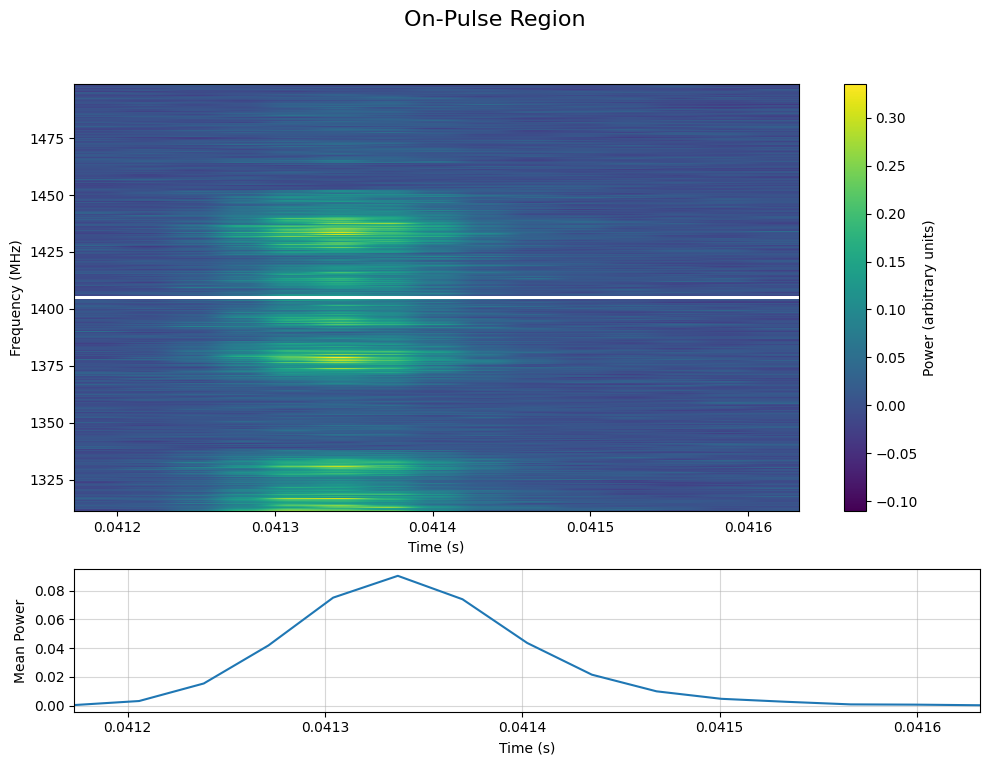

INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 1056)
INFO: Generating diagnostic plot: Off-Pulse (Noise) Region
INFO: Diagnostic plot saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/casey_off_pulse_diagnostic.png


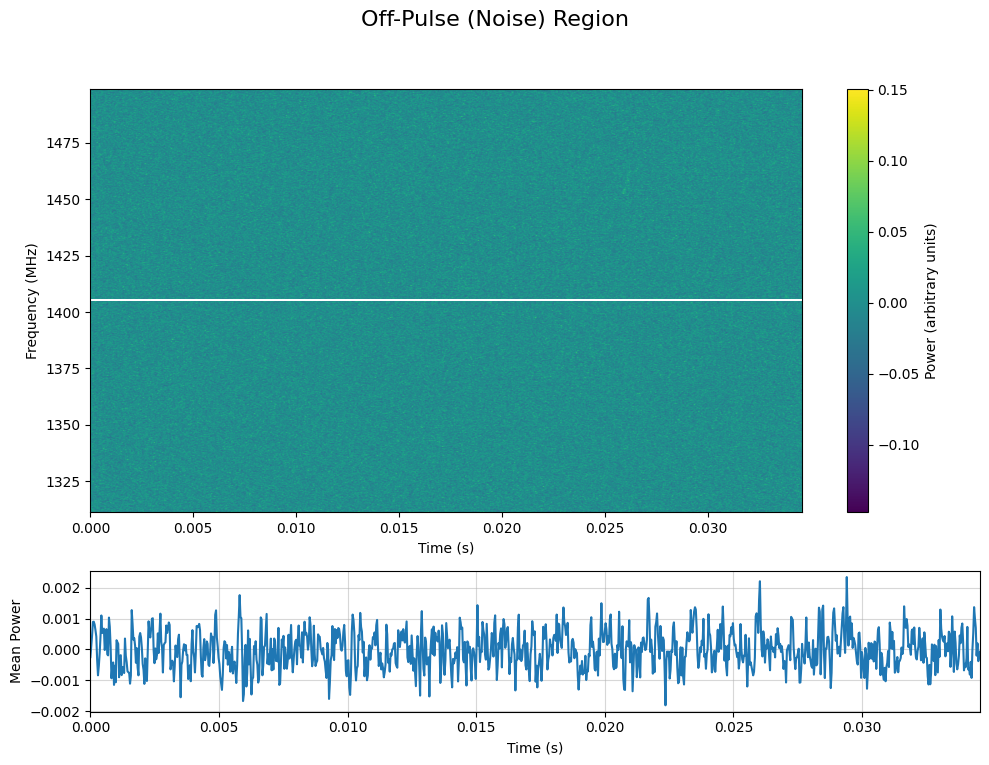

INFO: On/Off pulse diagnostic plots saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics
INFO: Generating baseline fit diagnostic plot.
INFO: Generating baseline fit diagnostic plot.
INFO: Baseline diagnostic plot saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/casey_baseline_diagnostic.png


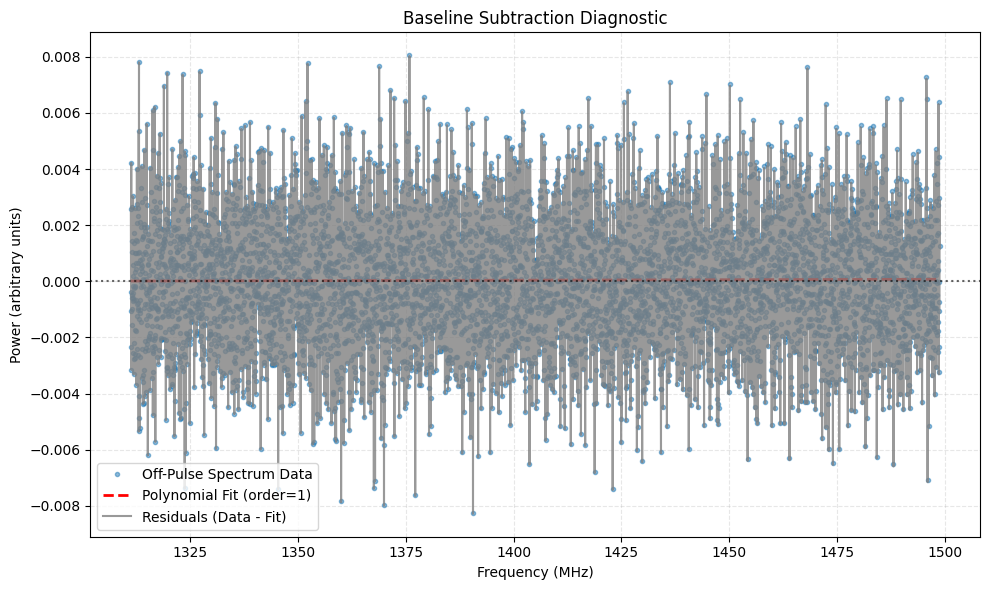

INFO: Characterizing off-pulse noise...
/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/scint_analysis/noise.py:145: UserWarning:

NaNs detected – in‑painting with row/col medians.

/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning:

All-NaN slice encountered

INFO: Noise characterization complete. Detected kind: 'flux_shiftedgamma'
INFO: Loading cached ACF results from /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/cache/casey/casey_acf_results.pkl
INFO: Running intra-pulse analysis...
INFO: Starting intra-pulse scintillation analysis...
Analyzing ACF vs. Time:   0%|          | 0/5 [00:00<?, ?it/s]


--- Initial Guesses for: fit_1c_lor ---
Parameters([('l1_gamma1', <Parameter 'l1_gamma1', value=0.05, bounds=[1e-06:inf]>), ('l1_m1', <Parameter 'l1_m1', value=0.8, bounds=[0:inf]>), ('l1_c1', <Parameter 'l1_c1', value=0.0, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_2c_lor ---
Parameters([('l2_gamma1', <Parameter 'l2_gamma1', value=1.55, bounds=[1e-06:inf]>), ('l2_m1', <Parameter 'l2_m1', value=0.29, bounds=[0:inf]>), ('l2_gamma2', <Parameter 'l2_gamma2', value=5.33, bounds=[1e-06:inf]>), ('l2_m2', <Parameter 'l2_m2', value=0.58, bounds=[0:inf]>), ('l2_c2', <Parameter 'l2_c2', value=0.01, bounds=[-inf:inf]>)])


/opt/pysetup/.venv/lib/python3.8/site-packages/uncertainties/core.py:1024: UserWarning:

Using UFloat objects with std_dev==0 may give unexpected results.




--- Initial Guesses for: fit_3c_lor ---
Parameters([('l3_gamma1', <Parameter 'l3_gamma1', value=0.01, bounds=[1e-06:inf]>), ('l3_m1', <Parameter 'l3_m1', value=0.3, bounds=[0:inf]>), ('l3_gamma2', <Parameter 'l3_gamma2', value=0.1, bounds=[1e-06:inf]>), ('l3_m2', <Parameter 'l3_m2', value=0.3, bounds=[0:inf]>), ('l3_gamma3', <Parameter 'l3_gamma3', value=0.3, bounds=[1e-06:inf]>), ('l3_m3', <Parameter 'l3_m3', value=0.3, bounds=[0:inf]>), ('l3_c3', <Parameter 'l3_c3', value=0.0, bounds=[-inf:inf]>)])


Analyzing ACF vs. Time:  20%|██        | 1/5 [00:01<00:04,  1.24s/it]


--- Initial Guesses for: fit_1c_lor ---
Parameters([('l1_gamma1', <Parameter 'l1_gamma1', value=0.05, bounds=[1e-06:inf]>), ('l1_m1', <Parameter 'l1_m1', value=0.8, bounds=[0:inf]>), ('l1_c1', <Parameter 'l1_c1', value=0.0, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_2c_lor ---
Parameters([('l2_gamma1', <Parameter 'l2_gamma1', value=1.55, bounds=[1e-06:inf]>), ('l2_m1', <Parameter 'l2_m1', value=0.29, bounds=[0:inf]>), ('l2_gamma2', <Parameter 'l2_gamma2', value=5.33, bounds=[1e-06:inf]>), ('l2_m2', <Parameter 'l2_m2', value=0.58, bounds=[0:inf]>), ('l2_c2', <Parameter 'l2_c2', value=0.01, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_3c_lor ---
Parameters([('l3_gamma1', <Parameter 'l3_gamma1', value=0.01, bounds=[1e-06:inf]>), ('l3_m1', <Parameter 'l3_m1', value=0.3, bounds=[0:inf]>), ('l3_gamma2', <Parameter 'l3_gamma2', value=0.1, bounds=[1e-06:inf]>), ('l3_m2', <Parameter 'l3_m2', value=0.3, bounds=[0:inf]>), ('l3_gamma3', <Parameter 'l3_gamma3', value=0.3, bounds=[1

Analyzing ACF vs. Time:  40%|████      | 2/5 [00:02<00:03,  1.19s/it]


--- Initial Guesses for: fit_1c_lor ---
Parameters([('l1_gamma1', <Parameter 'l1_gamma1', value=0.05, bounds=[1e-06:inf]>), ('l1_m1', <Parameter 'l1_m1', value=0.8, bounds=[0:inf]>), ('l1_c1', <Parameter 'l1_c1', value=0.0, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_2c_lor ---
Parameters([('l2_gamma1', <Parameter 'l2_gamma1', value=1.55, bounds=[1e-06:inf]>), ('l2_m1', <Parameter 'l2_m1', value=0.29, bounds=[0:inf]>), ('l2_gamma2', <Parameter 'l2_gamma2', value=5.33, bounds=[1e-06:inf]>), ('l2_m2', <Parameter 'l2_m2', value=0.58, bounds=[0:inf]>), ('l2_c2', <Parameter 'l2_c2', value=0.01, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_3c_lor ---
Parameters([('l3_gamma1', <Parameter 'l3_gamma1', value=0.01, bounds=[1e-06:inf]>), ('l3_m1', <Parameter 'l3_m1', value=0.3, bounds=[0:inf]>), ('l3_gamma2', <Parameter 'l3_gamma2', value=0.1, bounds=[1e-06:inf]>), ('l3_m2', <Parameter 'l3_m2', value=0.3, bounds=[0:inf]>), ('l3_gamma3', <Parameter 'l3_gamma3', value=0.3, bounds=[1

Analyzing ACF vs. Time:  60%|██████    | 3/5 [00:03<00:02,  1.01s/it]


--- Initial Guesses for: fit_1c_lor ---
Parameters([('l1_gamma1', <Parameter 'l1_gamma1', value=0.05, bounds=[1e-06:inf]>), ('l1_m1', <Parameter 'l1_m1', value=0.8, bounds=[0:inf]>), ('l1_c1', <Parameter 'l1_c1', value=0.0, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_2c_lor ---
Parameters([('l2_gamma1', <Parameter 'l2_gamma1', value=1.55, bounds=[1e-06:inf]>), ('l2_m1', <Parameter 'l2_m1', value=0.29, bounds=[0:inf]>), ('l2_gamma2', <Parameter 'l2_gamma2', value=5.33, bounds=[1e-06:inf]>), ('l2_m2', <Parameter 'l2_m2', value=0.58, bounds=[0:inf]>), ('l2_c2', <Parameter 'l2_c2', value=0.01, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_3c_lor ---
Parameters([('l3_gamma1', <Parameter 'l3_gamma1', value=0.01, bounds=[1e-06:inf]>), ('l3_m1', <Parameter 'l3_m1', value=0.3, bounds=[0:inf]>), ('l3_gamma2', <Parameter 'l3_gamma2', value=0.1, bounds=[1e-06:inf]>), ('l3_m2', <Parameter 'l3_m2', value=0.3, bounds=[0:inf]>), ('l3_gamma3', <Parameter 'l3_gamma3', value=0.3, bounds=[1

Analyzing ACF vs. Time:  80%|████████  | 4/5 [00:04<00:01,  1.11s/it]


--- Initial Guesses for: fit_1c_lor ---
Parameters([('l1_gamma1', <Parameter 'l1_gamma1', value=0.05, bounds=[1e-06:inf]>), ('l1_m1', <Parameter 'l1_m1', value=0.8, bounds=[0:inf]>), ('l1_c1', <Parameter 'l1_c1', value=0.0, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_2c_lor ---
Parameters([('l2_gamma1', <Parameter 'l2_gamma1', value=1.55, bounds=[1e-06:inf]>), ('l2_m1', <Parameter 'l2_m1', value=0.29, bounds=[0:inf]>), ('l2_gamma2', <Parameter 'l2_gamma2', value=5.33, bounds=[1e-06:inf]>), ('l2_m2', <Parameter 'l2_m2', value=0.58, bounds=[0:inf]>), ('l2_c2', <Parameter 'l2_c2', value=0.01, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_3c_lor ---
Parameters([('l3_gamma1', <Parameter 'l3_gamma1', value=0.01, bounds=[1e-06:inf]>), ('l3_m1', <Parameter 'l3_m1', value=0.3, bounds=[0:inf]>), ('l3_gamma2', <Parameter 'l3_gamma2', value=0.1, bounds=[1e-06:inf]>), ('l3_m2', <Parameter 'l3_m2', value=0.3, bounds=[0:inf]>), ('l3_gamma3', <Parameter 'l3_gamma3', value=0.3, bounds=[1

Analyzing ACF vs. Time: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
INFO: Intra-pulse analysis complete. Found results for 4 time slices.
INFO: Fitting models and deriving final scintillation parameters...
INFO: Fitting all ACF models to all sub-band ACFs...
Fitting Sub-band ACFs:   0%|          | 0/2 [00:00<?, ?it/s]


--- Initial Guesses for: fit_1c_lor ---
Parameters([('l1_gamma1', <Parameter 'l1_gamma1', value=0.05, bounds=[1e-06:inf]>), ('l1_m1', <Parameter 'l1_m1', value=0.8, bounds=[0:inf]>), ('l1_c1', <Parameter 'l1_c1', value=0.0, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_2c_lor ---
Parameters([('l2_gamma1', <Parameter 'l2_gamma1', value=1.55, bounds=[1e-06:inf]>), ('l2_m1', <Parameter 'l2_m1', value=0.29, bounds=[0:inf]>), ('l2_gamma2', <Parameter 'l2_gamma2', value=5.33, bounds=[1e-06:inf]>), ('l2_m2', <Parameter 'l2_m2', value=0.58, bounds=[0:inf]>), ('l2_c2', <Parameter 'l2_c2', value=0.01, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_3c_lor ---
Parameters([('l3_gamma1', <Parameter 'l3_gamma1', value=0.01, bounds=[1e-06:inf]>), ('l3_m1', <Parameter 'l3_m1', value=0.3, bounds=[0:inf]>), ('l3_gamma2', <Parameter 'l3_gamma2', value=0.1, bounds=[1e-06:inf]>), ('l3_m2', <Parameter 'l3_m2', value=0.3, bounds=[0:inf]>), ('l3_gamma3', <Parameter 'l3_gamma3', value=0.3, bounds=[1

Fitting Sub-band ACFs:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s]


--- Initial Guesses for: fit_1c_lor ---
Parameters([('l1_gamma1', <Parameter 'l1_gamma1', value=0.05, bounds=[1e-06:inf]>), ('l1_m1', <Parameter 'l1_m1', value=0.8, bounds=[0:inf]>), ('l1_c1', <Parameter 'l1_c1', value=0.0, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_2c_lor ---
Parameters([('l2_gamma1', <Parameter 'l2_gamma1', value=1.55, bounds=[1e-06:inf]>), ('l2_m1', <Parameter 'l2_m1', value=0.29, bounds=[0:inf]>), ('l2_gamma2', <Parameter 'l2_gamma2', value=5.33, bounds=[1e-06:inf]>), ('l2_m2', <Parameter 'l2_m2', value=0.58, bounds=[0:inf]>), ('l2_c2', <Parameter 'l2_c2', value=0.01, bounds=[-inf:inf]>)])

--- Initial Guesses for: fit_3c_lor ---
Parameters([('l3_gamma1', <Parameter 'l3_gamma1', value=0.01, bounds=[1e-06:inf]>), ('l3_m1', <Parameter 'l3_m1', value=0.3, bounds=[0:inf]>), ('l3_gamma2', <Parameter 'l3_gamma2', value=0.1, bounds=[1e-06:inf]>), ('l3_m2', <Parameter 'l3_m2', value=0.3, bounds=[0:inf]>), ('l3_gamma3', <Parameter 'l3_gamma3', value=0.3, bounds=[1

Fitting Sub-band ACFs: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]
INFO: --- Model Comparison (Lowest Total BIC is Best) ---
INFO: Model 'fit_1c_lor': Total BIC = -22767.10 (from 2 fits)
INFO: Model 'fit_3c_lor': Total BIC = -23388.82 (from 2 fits)
INFO: ==> Best overall model selected: fit_3c_lor
INFO: --- Pipeline execution finished. ---
INFO: Final results saved to ./casey_analysis_results.json
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1256 and 1271.
INFO: Generating intra-pulse evolution plot with 2D ACF heatmap.


--- Pipeline Execution Finished ---

--- Saving results to ./casey_analysis_results.json ---

--- Generating Intra-Pulse Evolution Plot ---


/opt/pysetup/.venv/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning:


INFO: Intra-pulse evolution plot saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/casey_intra_pulse_evolution.png


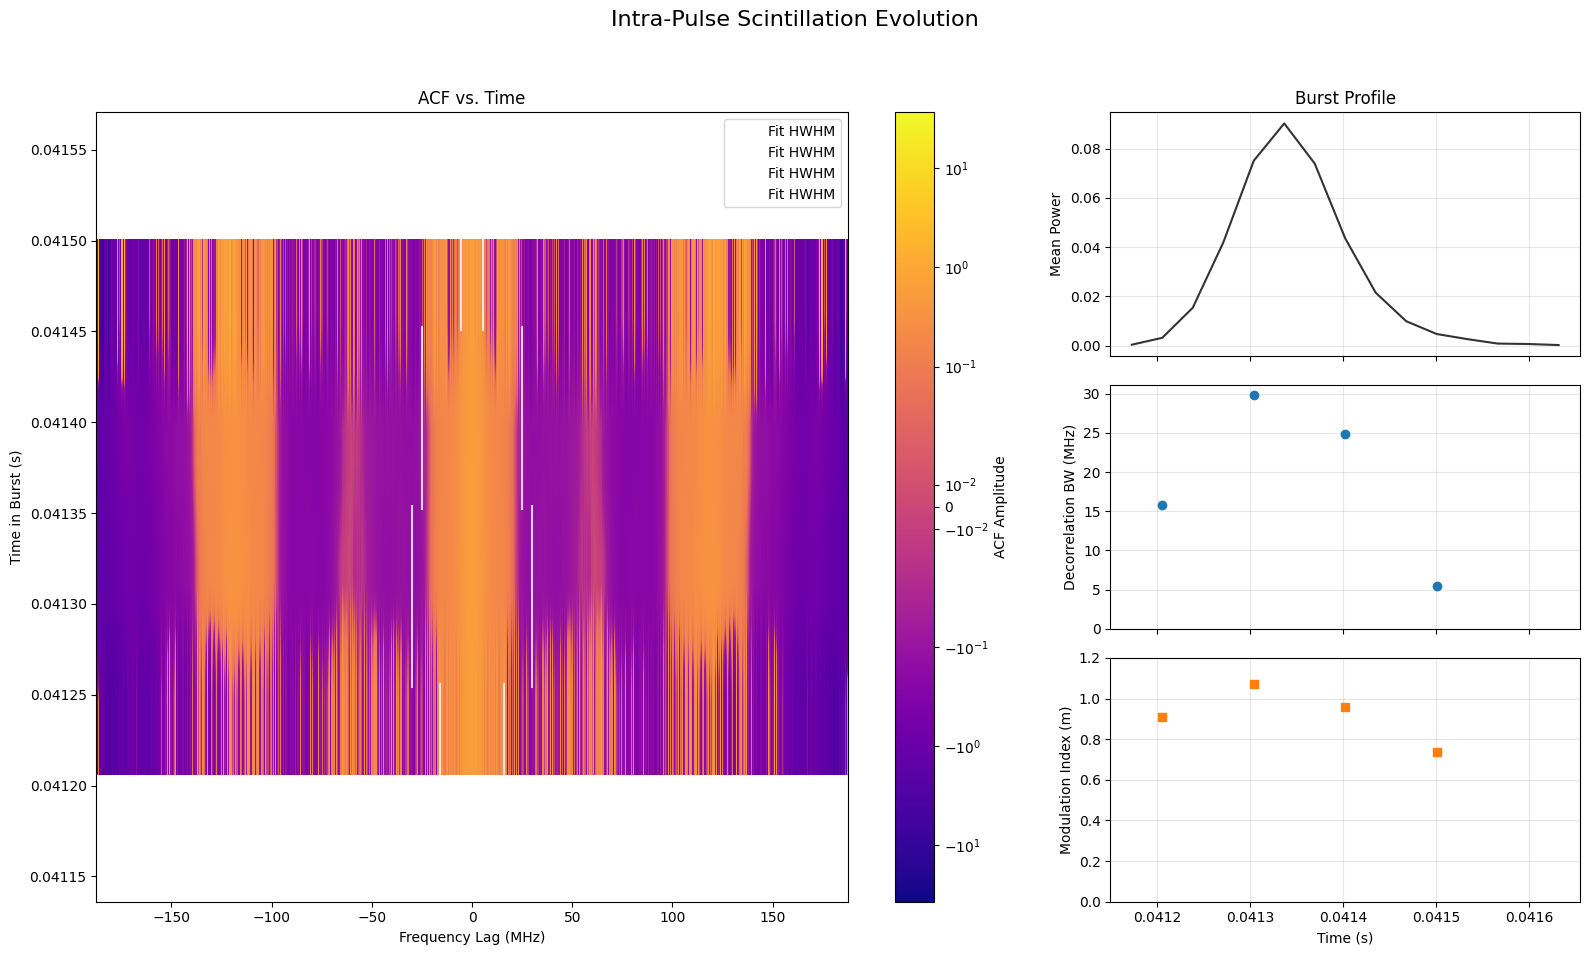

INFO: Generating full analysis overview plot.



--- Generating Final Analysis Plot ---
Saved plots to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/casey/casey_analysis_overview.png


INFO: Analysis overview plot saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/casey/casey_analysis_overview.png


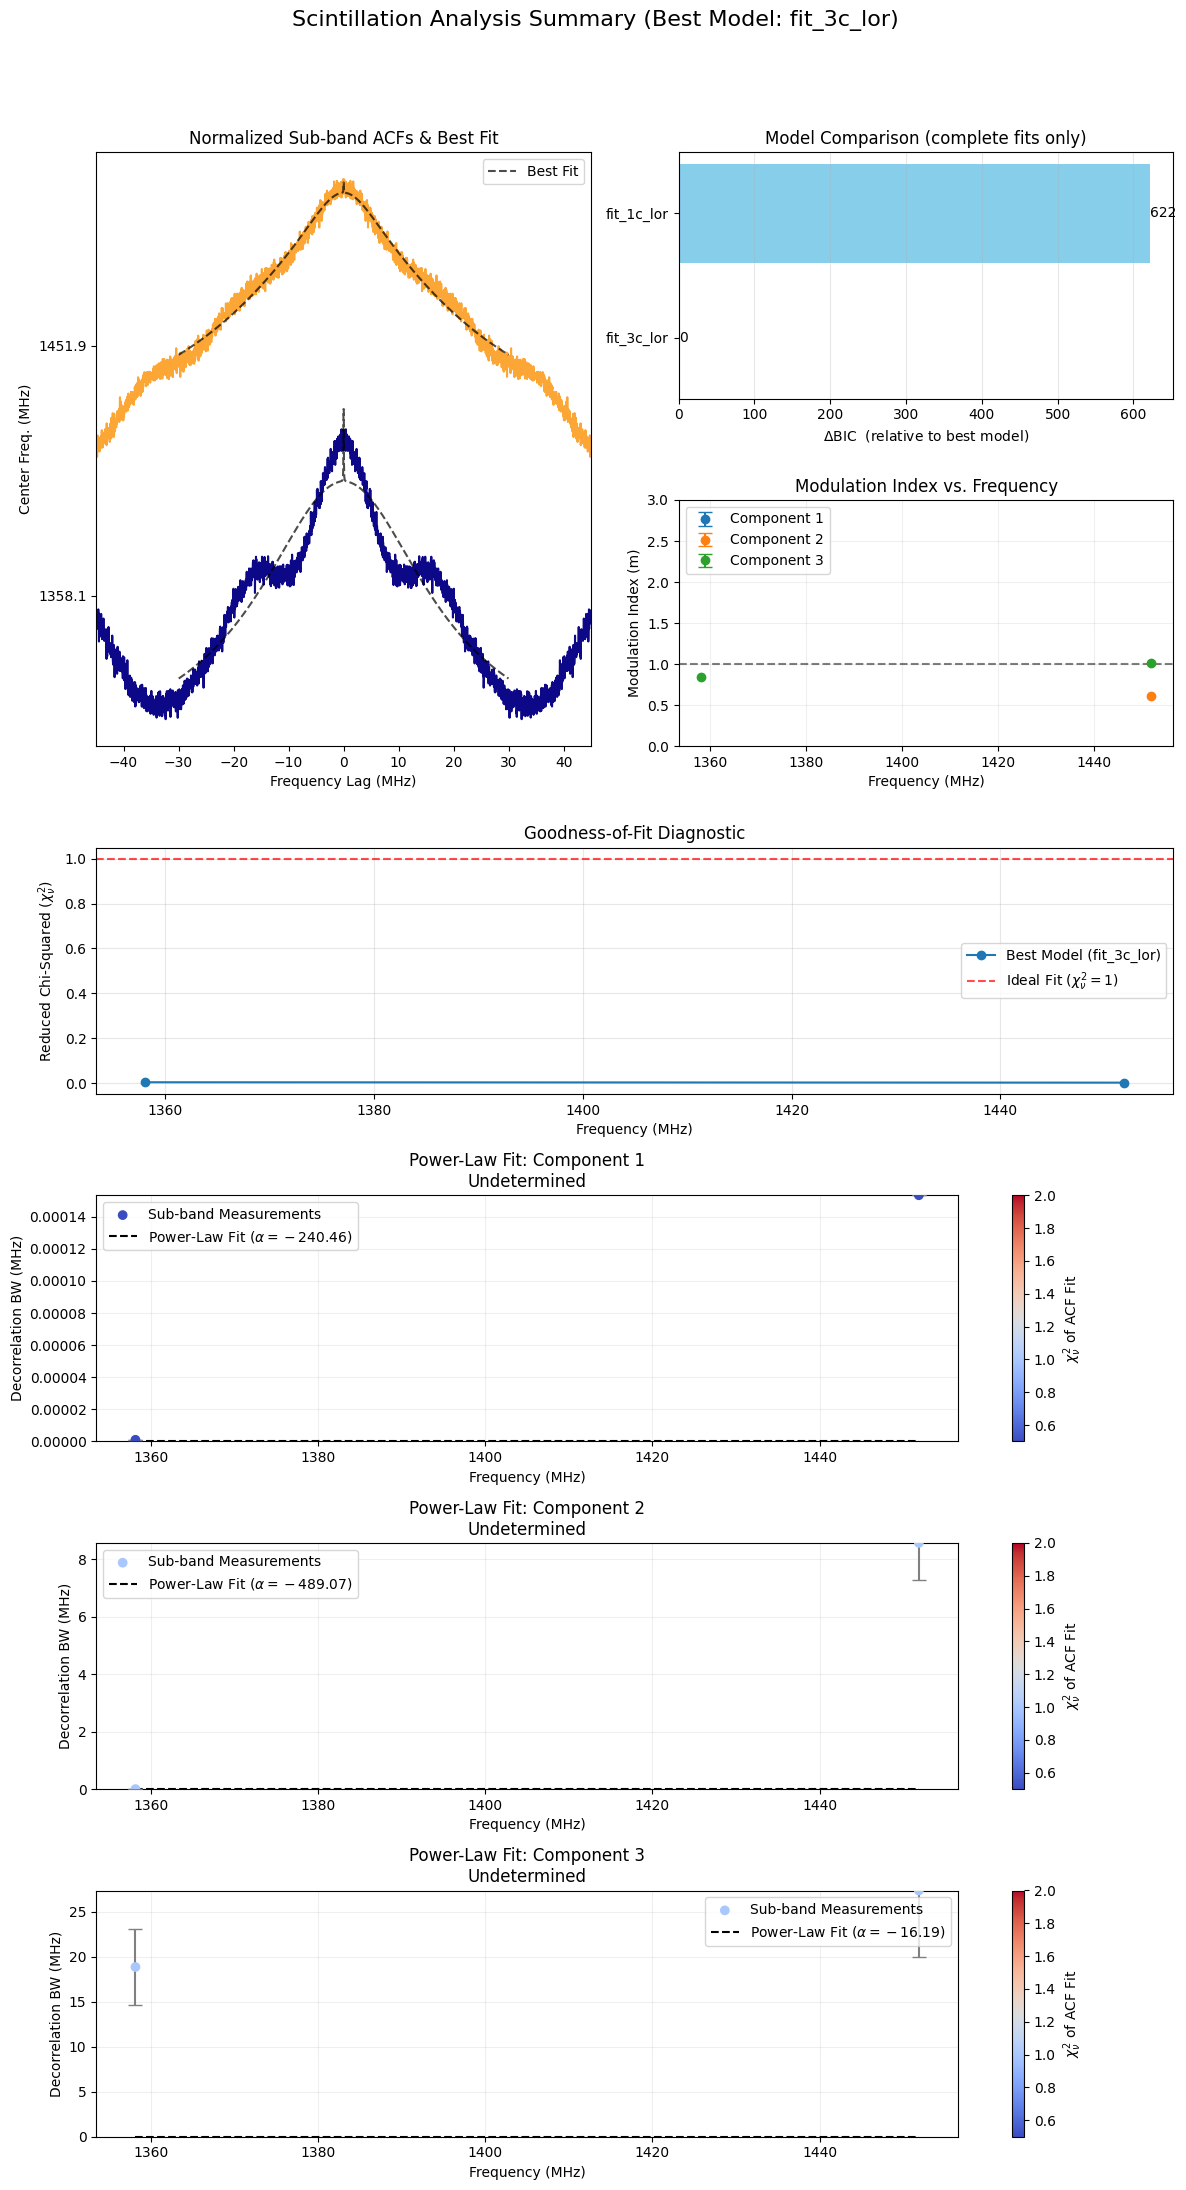

In [65]:
# Set path for module imports
import sys
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

%load_ext autoreload
%autoreload 2

import json
import logging
import numpy as np
import matplotlib.pyplot as plt


# Import the main pipeline components
from scint_analysis import config, pipeline, plotting
# Import your new noise model if you need to use it separately
# from scint_analysis import noise_model 

# --- 1. Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey_dsa.yaml'

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")
    # Stop execution if config fails
    raise

# --- 2. Initialize and Run the Pipeline ---
print("\n--- Initializing and Running Scintillation Pipeline ---")
# Create an instance of the main pipeline controller
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

# This single .run() call executes all the steps in the correct order:
# - Loads and masks data
# - Characterizes off-pulse noise (NEW)
# - Calculates ACFs using the noise model for normalization
# - Fits all models and derives final parameters
scint_pipeline.run()
print("--- Pipeline Execution Finished ---")


# --- 3. Save and Plot Results ---
# Save the final parameters to a JSON file
if scint_pipeline.final_results:
    output_json_path = f"./{analysis_config.get('burst_id', 'output')}_analysis_results.json"
    
    print(f"\n--- Saving results to {output_json_path} ---")

    with open(output_json_path, 'w') as f:
        json.dump(scint_pipeline.final_results, f, indent=4)
        
    logging.info(f"Final results saved to {output_json_path}")

# Generate Intra-Pulse Evolution Plot
print("\n--- Generating Intra-Pulse Evolution Plot ---")

# Check if the intra-pulse analysis was run and produced results
if scint_pipeline.intra_pulse_results:
    # We need the on-pulse time series for context in the plot.
    # First, get the dynamic spectrum object from the pipeline.
    spectrum = scint_pipeline.masked_spectrum
    
    # Recalculate the burst limits to ensure we have the correct window
    # (This uses the same config parameters as the pipeline run)
    rfi_config = analysis_config.get('analysis', {}).get('rfi_masking', {})
    burst_lims = spectrum.find_burst_envelope(
        thres=rfi_config.get('find_burst_thres', 5.0),
        padding_factor=rfi_config.get('padding_factor', 2.0)
    )

    # Get the on-pulse profile and its corresponding time axis
    on_pulse_profile = spectrum.get_profile(time_window_bins=burst_lims)
    on_pulse_times = spectrum.times[burst_lims[0]:burst_lims[1]]

    # Define a path to save the new plot
    plot_options = analysis_config.get('pipeline_options', {}).get('diagnostic_plots', {})
    if plot_options.get('enable', False):
        plot_dir = plot_options.get('directory', './plots/diagnostics')
        burst_id = analysis_config.get('burst_id', 'unknown_burst')
        save_path = f"{plot_dir}/{burst_id}_intra_pulse_evolution.png"
    else:
        save_path = None

    # Call the new plotting function with the results from the pipeline
    plotting.plot_intra_pulse_evolution(
        intra_pulse_results=scint_pipeline.intra_pulse_results,
        on_pulse_profile=on_pulse_profile,
        on_pulse_times=on_pulse_times,
        save_path=save_path
    )
else:
    logging.warning("Intra-pulse analysis was not enabled in the config or produced no results. Skipping evolution plot.")

    
# Generate the final overview plot using the results stored in the pipeline object
print("\n--- Generating Final Analysis Plot ---")
if scint_pipeline.final_results and scint_pipeline.all_subband_fits:
    # Get the plot save path from the config, as we implemented
    save_path = analysis_config.get('pipeline_options', {}).get('output_plot_path')
    print(f'Saved plots to: {save_path}')
    
    plotting.plot_analysis_overview(
        analysis_results=scint_pipeline.final_results,
        acf_results=scint_pipeline.acf_results,
        all_subband_fits=scint_pipeline.all_subband_fits,
        all_powerlaw_fits=scint_pipeline.all_powerlaw_fits,
        save_path=save_path
    )
else:
    logging.warning("Pipeline did not produce final results, skipping plot.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


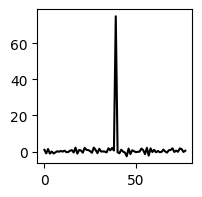

INFO: Loading burst configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey.yaml
INFO: Loading telescope configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/../telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.
INFO: Loading DynamicSpectrum from file: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/dsa110-scat/scintillation/scint_analysis/data/casey.npz


--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "casey",
  "input_data_path": "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/dsa110-scat/scintillation/scint_analysis/data/casey.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 5.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0
    },
    "acf": {
      "num_subbands": 4,
      "max_lag_mhz": 45.0,
      "use_snr_subbanding": true
    },
    "fitting": {
      "fit_lagrange_mhz": 45.0,
      "reference_frequency_mhz": 1400.0
    }
  },
  "pipeline_options": {
    "log_level": "INFO",
    "save_intermediate_step

INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Generating dynamic spectrum plot.


Raw spectrum loaded successfully.
<DynamicSpectrum (6144 channels x 2500 timesteps, 1311.2-1498.8 MHz)>

Displaying raw dynamic spectrum...


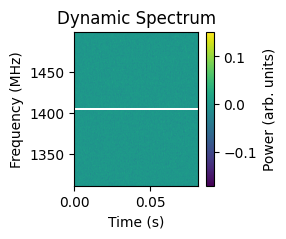

INFO: Applying RFI masking.
INFO: Using time downsampling factor of 16 for RFI statistical checks.
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1256 and 1271.
INFO: Using symmetric noise window of duration 15 bins.
INFO: Using downsampled noise statistics from bins 77 to 78.



Applying RFI masking...


Iterative RFI Masking in Frequency Domain: 100%|██████████| 5/5 [00:00<00:00, 694.28it/s]
INFO: Masked 0 channels based on frequency-domain stats.
INFO: Skipping time-domain RFI flagging as per configuration.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Generating dynamic spectrum plot.


RFI masking complete.

Displaying RFI-masked dynamic spectrum...


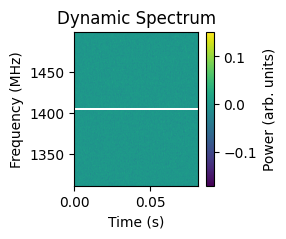

INFO: Starting sub-band ACF calculations.
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1256 and 1271.



Calculating ACFs for all sub-bands (this may take a moment)...


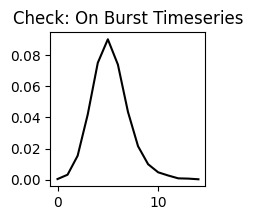

INFO: Using symmetric noise window of duration 15 bins.
Calculating sub-band ACFs: 100%|██████████| 4/4 [00:00<00:00, 44.57it/s]
INFO: Fitting all ACF models to all sub-band ACFs...


ACF calculation complete.

ACF Results Dictionary Keys: dict_keys(['subband_acfs', 'subband_lags_mhz', 'subband_center_freqs_mhz', 'subband_channel_widths_mhz', 'subband_num_channels'])
Computed ACFs for 4 sub-bands.

Fitting models and deriving final scintillation parameters...


INFO: --- Model Comparison (Lowest Total BIC is Best) ---
INFO: Model 'fit_1c_lor': Total BIC = -36581.65 (from 4 fits)
INFO: Model 'fit_2c_lor': Total BIC = -24808.99 (from 3 fits)
INFO: Model 'fit_1c_gauss': Total BIC = -36186.73 (from 4 fits)
INFO: Model 'fit_2c_gauss': Total BIC = -25794.16 (from 3 fits)
INFO: ==> Best overall model selected: fit_1c_lor
INFO: Generating full analysis overview plot.


Analysis complete.

--- Final Derived Parameters ---
{
  "best_model": "fit_1c_lor",
  "components": {
    "scint_scale": {
      "power_law_fit_report": [
        2.010124792228405e-09,
        2.8364871387202912
      ],
      "scaling_index": 2.8364871387202912,
      "scaling_index_err": 19.183037981321714,
      "bw_at_ref_mhz": 1.6872317140451365,
      "bw_at_ref_mhz_err": 0.8493381502928066,
      "subband_measurements": [
        {
          "freq_mhz": 1324.4815236854959,
          "bw": 2.302610996664314,
          "mod": 0.3977613801984734,
          "bw_err": 0.12556720679626796,
          "finite_err": 0.33941468231261723
        },
        {
          "freq_mhz": 1365.2901676705194,
          "bw": 12.721848432969393,
          "mod": 1.140616544032408,
          "bw_err": 0.0768978557125016,
          "finite_err": 3.055808106466236
        },
        {
          "freq_mhz": 1410.829806283575,
          "bw": 1.348577332124393,
          "mod": 0.24526926969015905,
    

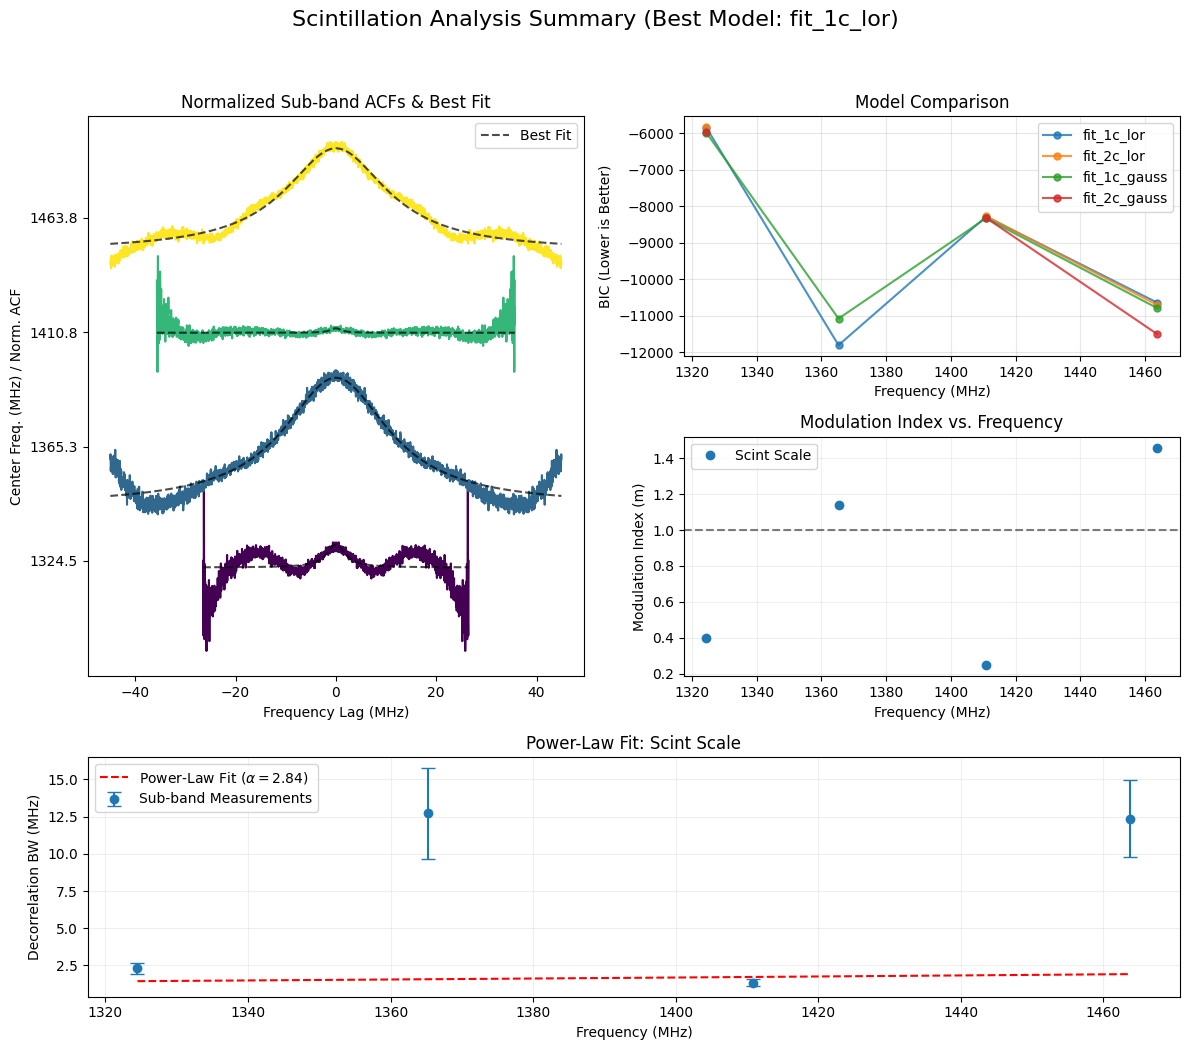

In [6]:
# Set path for module imports
import sys, os
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

%load_ext autoreload
%autoreload 2

import logging
import json
import importlib
import numpy as np

import matplotlib.pyplot as plt

# Import all modules from our new package

from scint_analysis import config
from scint_analysis import core
from scint_analysis import analysis
from scint_analysis import plotting

# --- Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey.yaml'

casey = np.load('/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/dsa110-scat/scintillation/scint_analysis/data/casey_dsa_I_491_211_2500b_cntr_bpc.npy')
downsample_factor = 32
prof = np.nansum(casey,axis=0)
n = prof.size - (prof.size % downsample_factor)
prof = prof[:n].reshape(-1, downsample_factor).mean(axis=1)
    
fig = plt.figure(figsize = (2, 2))
plt.plot(prof, c ='k')
plt.show()

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    # Pretty-print the configuration to verify it
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")

# Load the dynamic spectrum from the path specified in the config
try:
    raw_spectrum = core.DynamicSpectrum.from_numpy_file(analysis_config['input_data_path'])
    print("Raw spectrum loaded successfully.")
    print(raw_spectrum)
except Exception as e:
    logging.error(f"Failed to load data: {e}")

# --- Visualization Step 1: Inspect Raw Data ---
if 'raw_spectrum' in locals():
    print("\nDisplaying raw dynamic spectrum...")
    plotting.plot_dynamic_spectrum(raw_spectrum, figsize=(2, 2))

# --- Perform RFI Masking ---
if 'raw_spectrum' in locals():
    print("\nApplying RFI masking...")
    masked_spectrum = raw_spectrum.mask_rfi(analysis_config)
    print("RFI masking complete.")

    # --- Visualization Step 2: Inspect Masked Data ---
    print("\nDisplaying RFI-masked dynamic spectrum...")
    plotting.plot_dynamic_spectrum(masked_spectrum, figsize=(2, 2))

# --- Calculate ACFs for all sub-bands ---
if 'masked_spectrum' in locals():
    print("\nCalculating ACFs for all sub-bands (this may take a moment)...")
    acf_results = analysis.calculate_acfs_for_subbands(masked_spectrum, analysis_config)
    print("ACF calculation complete.")
    
    # You can inspect the structure of the results
    print("\nACF Results Dictionary Keys:", acf_results.keys())
    print(f"Computed ACFs for {len(acf_results['subband_acfs'])} sub-bands.")
    
# --- Run the final analysis and fitting stage ---
if 'acf_results' in locals() and acf_results['subband_acfs']:
    print("\nFitting models and deriving final scintillation parameters...")
    # This function returns both the final parameters and the raw lmfit objects
    final_results, all_subband_fits, powlaw_fit_params = analysis.analyze_scintillation_from_acfs(acf_results, analysis_config)
    print("Analysis complete.")

    # --- Inspect the Final Results ---
    print("\n--- Final Derived Parameters ---")
    print(json.dumps(final_results, indent=2))
else:
    logging.error("ACF results not available. Cannot proceed to final analysis.")
    
# --- Generate the final overview plot ---
if 'final_results' in locals() and 'all_subband_fits' in locals():
    print("\nGenerating final analysis overview plot...")
    plotting.plot_analysis_overview(
        filename='../casey_dsa_scint.pdf',
        analysis_results=final_results,
        acf_results=acf_results,
        all_subband_fits=all_subband_fits,
        powlaw_fit_params=powlaw_fit_params
    )
else:
    logging.warning("Final results not available, skipping overview plot.")


In [6]:
# Import all modules from our new package
import scint_analysis
importlib.reload(scint_analysis)
from scint_analysis import config, core, analysis, plotting

# --- Run the final analysis and fitting stage ---
if 'acf_results' in locals() and acf_results['subband_acfs']:
    print("\nFitting models and deriving final scintillation parameters...")
    # This function returns both the final parameters and the raw lmfit objects
    final_results, all_subband_fits, powlaw_fit_params = analysis.analyze_scintillation_from_acfs(acf_results, analysis_config)
    print("Analysis complete.")

    # --- Inspect the Final Results ---
    print("\n--- Final Derived Parameters ---")
    print(json.dumps(final_results, indent=2))
else:
    logging.error("ACF results not available. Cannot proceed to final analysis.")


INFO: Fitting Lorentzian models to all sub-band ACFs...
/opt/pysetup/.venv/lib/python3.8/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")



Fitting models and deriving final scintillation parameters...


INFO: Model selection complete. Best overall model: 1 component(s).


Analysis complete.

--- Final Derived Parameters ---
{
  "best_model": 1,
  "components": {
    "scint_scale": {
      "power_law_fit_report": [
        2.010124792228405e-09,
        2.8364871387202912
      ],
      "scaling_index": 2.8364871387202912,
      "scaling_index_err": 19.183037981321714,
      "bw_at_ref_mhz": 1.6872317140451365,
      "bw_at_ref_mhz_err": 0.8493381502928066,
      "subband_measurements": [
        {
          "freq_mhz": 1324.4815236854959,
          "bw": 2.302610996664314,
          "mod": 0.3977613801984734,
          "bw_err": 0.12556720679626796,
          "finite_err": 0.33941468231261723
        },
        {
          "freq_mhz": 1365.2901676705194,
          "bw": 12.721848432969393,
          "mod": 1.140616544032408,
          "bw_err": 0.0768978557125016,
          "finite_err": 3.055808106466236
        },
        {
          "freq_mhz": 1410.829806283575,
          "bw": 1.348577332124393,
          "mod": 0.24526926969015905,
          "bw_e